In [1]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import os
os.chdir("/home/jakob/doktor/projects/EnsembleUncertainty/code")
"""Learing "logit" distribution in regression example"""
from pathlib import Path
from datetime import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import torch

from src.dataloaders import gaussian_sinus, one_dim_regression
import src.utils as utils
from src.distilled import gauss_logits, gauss_mix, norm_inv_wish
from src.ensemble import simple_regressor, ensemble

import src.metrics as metrics
import src.loss as custom_loss
from src import utils

LOGGER = logging.getLogger(__name__)
EXPERIMENT_NAME = "regression_logits"

# Settings
class Args():
    pass
args = Args()
args.seed = 1
args.gpu = True
args.log_dir = Path("./logs")

args.log_level = logging.INFO
args.retrain = True

args.num_ensemble_members=10
args.num_epochs=100
args.lr = 0.01
plt.rcParams['figure.figsize'] = [30, 15]

tex_dir = Path("/home/jakob/doktor/projects/EnsembleUncertainty/paper/Paper")

In [2]:
def make_plots(distilled_model, data):
    test_loader = torch.utils.data.DataLoader(data,
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=0)

    predictions = np.zeros((data.n_samples, distilled_model.output_size))
    all_x = np.zeros((data.n_samples, 1))
    all_y = np.zeros((data.n_samples, 1))

    idx = 0
    for batch in test_loader:
        inputs, targets = batch

        predictions[idx * test_loader.batch_size:(idx + 1) * test_loader.batch_size, :, :] = \
            distilled_model.predict(inputs, t=None).data.numpy()

        all_x[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = inputs
        all_y[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = targets

        idx += 1

    plt.scatter(np.squeeze(all_x), np.squeeze(all_y), label="Data", marker=".")

    plt.errorbar(np.squeeze(all_x),
                 predictions[:, 0],
                 np.sqrt(predictions[:, 1]),
                 label="Distilled model predictions",
                 marker=".",
                 ls="none")

    plt.legend()
    plt.show()


In [3]:
log_file = Path("{}_{}.log".format(
    EXPERIMENT_NAME,
    datetime.now().strftime("%Y%m%d_%H%M%S")))
utils.setup_logger(log_path=Path.cwd() / args.log_dir / log_file,
                   log_level=args.log_level)
LOGGER.info("Args: {}".format(args))
device = utils.torch_settings(args.seed, args.gpu)
LOGGER.info("Creating dataloader")
data = gaussian_sinus.GaussianSinus(range_=(-3, 3), store_file=Path("none"))

input_size = 1
ensemble_output_size = 2
layer_sizes = [1, 10, 10, ensemble_output_size] # Mean and variance
args.num_ensemble_members = 2
args.num_epochs=2
args.lr = 0.001
args.log_level = logging.INFO
train_loader = torch.utils.data.DataLoader(data,
                                           batch_size=32,
                                           shuffle=True)

prob_ensemble = ensemble.Ensemble(ensemble_output_size)
for _ in range(args.num_ensemble_members):

    model = simple_regressor.Model(layer_sizes=layer_sizes,
                                 device=device,
                                 variance_transform=utils.positive_linear_asymptote(),
                                 loss_function=custom_loss.gaussian_neg_log_likelihood_1d)
    model.optimizer = torch.optim.Adam(model.parameters(),
                                         lr=args.lr)
    #model.switch_active_network("mu")
    prob_ensemble.add_member(model)
squared_error_metric = metrics.Metric(name="MSE",
                                      function=metrics.mean_squared_error)
prob_ensemble.add_metrics([squared_error_metric])
prob_ensemble.train(train_loader, args.num_epochs)

2020-07-02 14:14:12,085 INFO  root            - Log at /home/jakob/doktor/projects/EnsembleUncertainty/code/logs/regression_logits_20200702_141412.log
2020-07-02 14:14:12,086 INFO  __main__        - Args: <__main__.Args object at 0x7f02c0ae2908>
2020-07-02 14:14:12,115 INFO  __main__        - Creating dataloader
2020-07-02 14:14:12,116 INFO  GaussianSinus   - Sampling new data
2020-07-02 14:14:12,358 INFO  Model           - Moving model to device: cuda
2020-07-02 14:14:12,359 INFO  Model           - Using variance transform: <lambda>
2020-07-02 14:14:14,092 WARNING Ensemble        - Is subclass check disabled
2020-07-02 14:14:14,093 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-07-02 14:14:14,094 INFO  Model           - Moving model to device: cuda
2020-07-02 14:14:14,094 INFO  Model           - Using variance transform: <lambda>
2020-07-02 14:14:14,096 WARNING Ensemble        - Is subclass check disabled
2020-07-02 14:14:14,096 INFO  Ens

In [4]:
test_data_set = gaussian_sinus.GaussianSinus(range_=(-5, 5),
                                             store_file=Path("tmp_data"))
test_data = test_data_set.get_full_data(sorted_=True)

with torch.no_grad():
    N = len(test_data)
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((N, 1))
    ens_output = prob_ensemble.predict(x).cpu()
    x = x.reshape(y.size())
mus, sigma_sqs = ens_output[:, : ,0], ens_output[:, : ,1]

mu_ens, sigma_sq = utils.gaussian_mixture_moments(mus, sigma_sqs)

2020-07-02 14:14:21,464 INFO  GaussianSinus   - Sampling new data


In [5]:
#Create distilled!
hidden_size = 10
distilled_output_size = ensemble_output_size * 2
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
distilled_model = gauss_logits.Model(
    layer_sizes=layer_sizes,
    variance_transform=utils.positive_linear_asymptote(),
    teacher=prob_ensemble,
    device=device,
    learning_rate=args.lr)

2020-07-02 14:14:24,303 WARNING Model           - Must assign proper loss function to child.loss.
2020-07-02 14:14:24,303 INFO  Model           - Moving model to device: cuda


In [6]:
# Retrain!
lower = -5
upper = 5
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)


distilled_model.train(unlabelled_loader, 2)

2020-07-02 14:14:27,300 INFO  GaussianSinus   - Sampling new data
2020-07-02 14:14:27,496 INFO  Model           - Training distilled network.
2020-07-02 14:14:31,876 INFO  Model           - Epoch 1: Loss: 66.70824682712555
2020-07-02 14:14:35,948 INFO  Model           - Epoch 2: Loss: 54.45709800720215


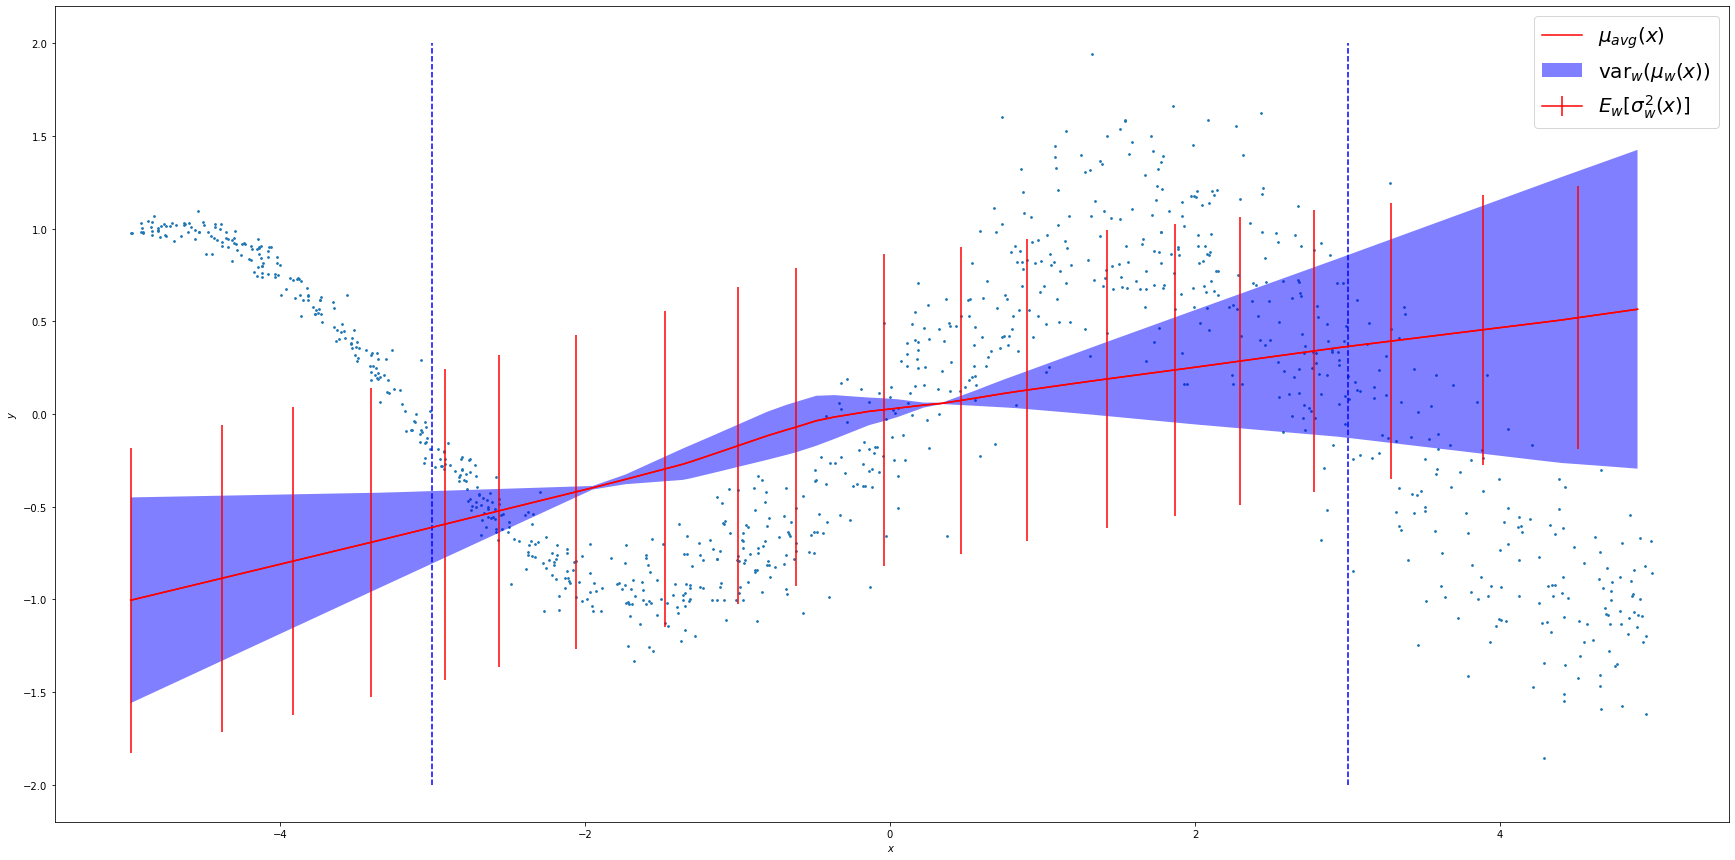

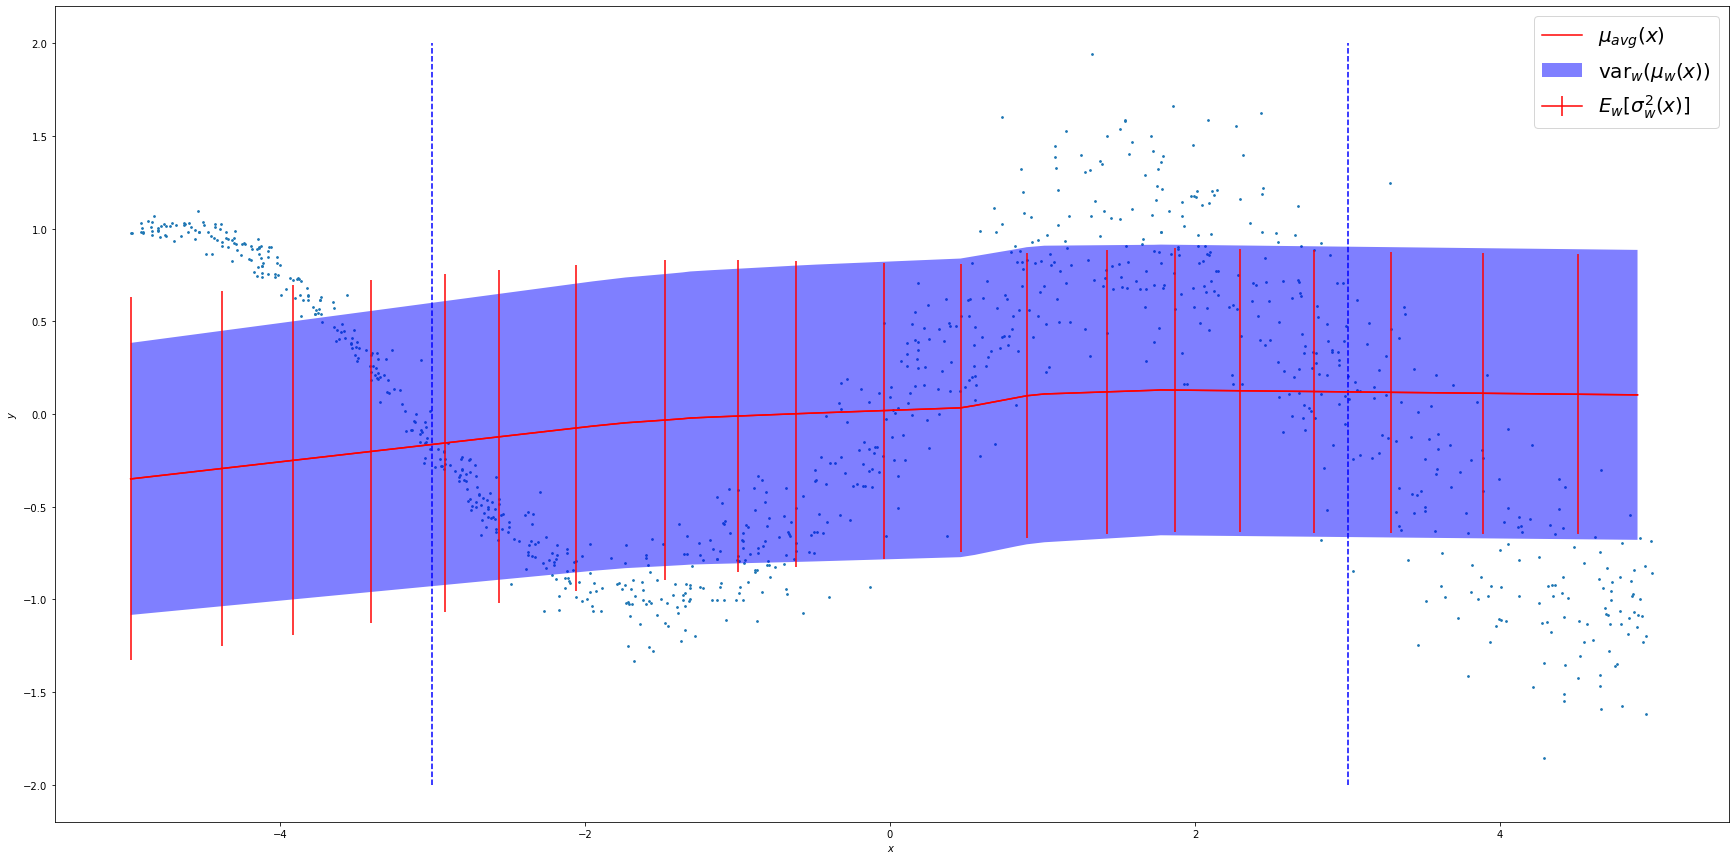

In [7]:
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    ens_output = prob_ensemble.predict(x).cpu()
    z_mean, z_var = distilled_model.forward(x.to(device))
    z_mean, z_var = z_mean.cpu(), z_var.cpu()
    x = x.reshape(y.size())
    

mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)
#mean_mu_ens = torch.mean(mu_ens, dim=1)
ale_ens, epi_ens = metrics.uncertainty_separation_parametric(mu_ens, sigma_sq_ens)

mu_dist = z_mean[:, 0]
ale_dist = torch.log( 1 + torch.exp(z_mean[:, 1]))
epi_dist = z_var[:, 1]
_, true_mean, true_sigma = test_data_set.x_to_y_mapping(x)

#_, ax = plt.subplots()
#utils.plot_uncert(ax, x, y, mean_mu=true_mean, every_nth=10, ale=np.sqrt(true_sigma), epi=None)
#tikzplotlib.save("fig/toy_example/data.tikz")
_, ax = plt.subplots()
utils.plot_uncert(ax, x, y, mean_mu=mean_mu_ens,every_nth=10, ale=ale_ens, epi=epi_ens)
#tikzplotlib.save("fig/toy_example/ensemble_mu_uncert.tikz")
_, ax = plt.subplots()
utils.plot_uncert(ax, x, y, mean_mu=mu_dist, every_nth=10, ale=ale_dist, epi=epi_dist)
#tikzplotlib.save("fig/toy_example/distilled_mu_uncert.tikz")

In [8]:
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    output = prob_ensemble.predict(x)
mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)

gauss_param = (mean_mu_ens.unsqueeze_(1), mean_sigma_sq_ens.unsqueeze_(1))
mixture_targets = (mu_ens, sigma_sq_ens)
custom_loss.kl_div_gauss_and_mixture_of_gauss(gauss_param, mixture_targets)

tensor([0.8386])

In [9]:
#Create mixture!
hidden_size = 10
distilled_output_size = ensemble_output_size
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
gauss_mix_distilled = gauss_mix.Model(layer_sizes=layer_sizes,
                                      teacher=prob_ensemble,
                                      loss_function=custom_loss.kl_div_gauss_and_mixture_of_gauss,
                                      device=device)
gauss_mix_distilled.optimizer = torch.optim.Adam(gauss_mix_distilled.parameters(),
                                                 lr=args.lr)

# Retrain!
lower = -5
upper = 5
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)


gauss_mix_distilled.train(unlabelled_loader, 50)

2020-07-02 14:16:13,383 WARNING Model           - Must assign proper loss function to child.loss.
2020-07-02 14:16:13,383 INFO  Model           - Moving model to device: cuda
2020-07-02 14:16:13,384 INFO  Model           - Using variance transform: <lambda>
2020-07-02 14:16:13,386 INFO  GaussianSinus   - Sampling new data
2020-07-02 14:16:13,588 INFO  Model           - Training distilled network.
2020-07-02 14:16:14,390 INFO  Model           - Epoch 1: Loss: 36.637614011764526
2020-07-02 14:16:14,863 INFO  Model           - Epoch 2: Loss: 33.203354597091675
2020-07-02 14:16:15,340 INFO  Model           - Epoch 3: Loss: 29.849379658699036
2020-07-02 14:16:15,818 INFO  Model           - Epoch 4: Loss: 26.786018133163452
2020-07-02 14:16:16,295 INFO  Model           - Epoch 5: Loss: 24.797668278217316
2020-07-02 14:16:16,774 INFO  Model           - Epoch 6: Loss: 23.404920041561127
2020-07-02 14:16:17,244 INFO  Model           - Epoch 7: Loss: 22.516926527023315
2020-07-02 14:16:17,694 IN

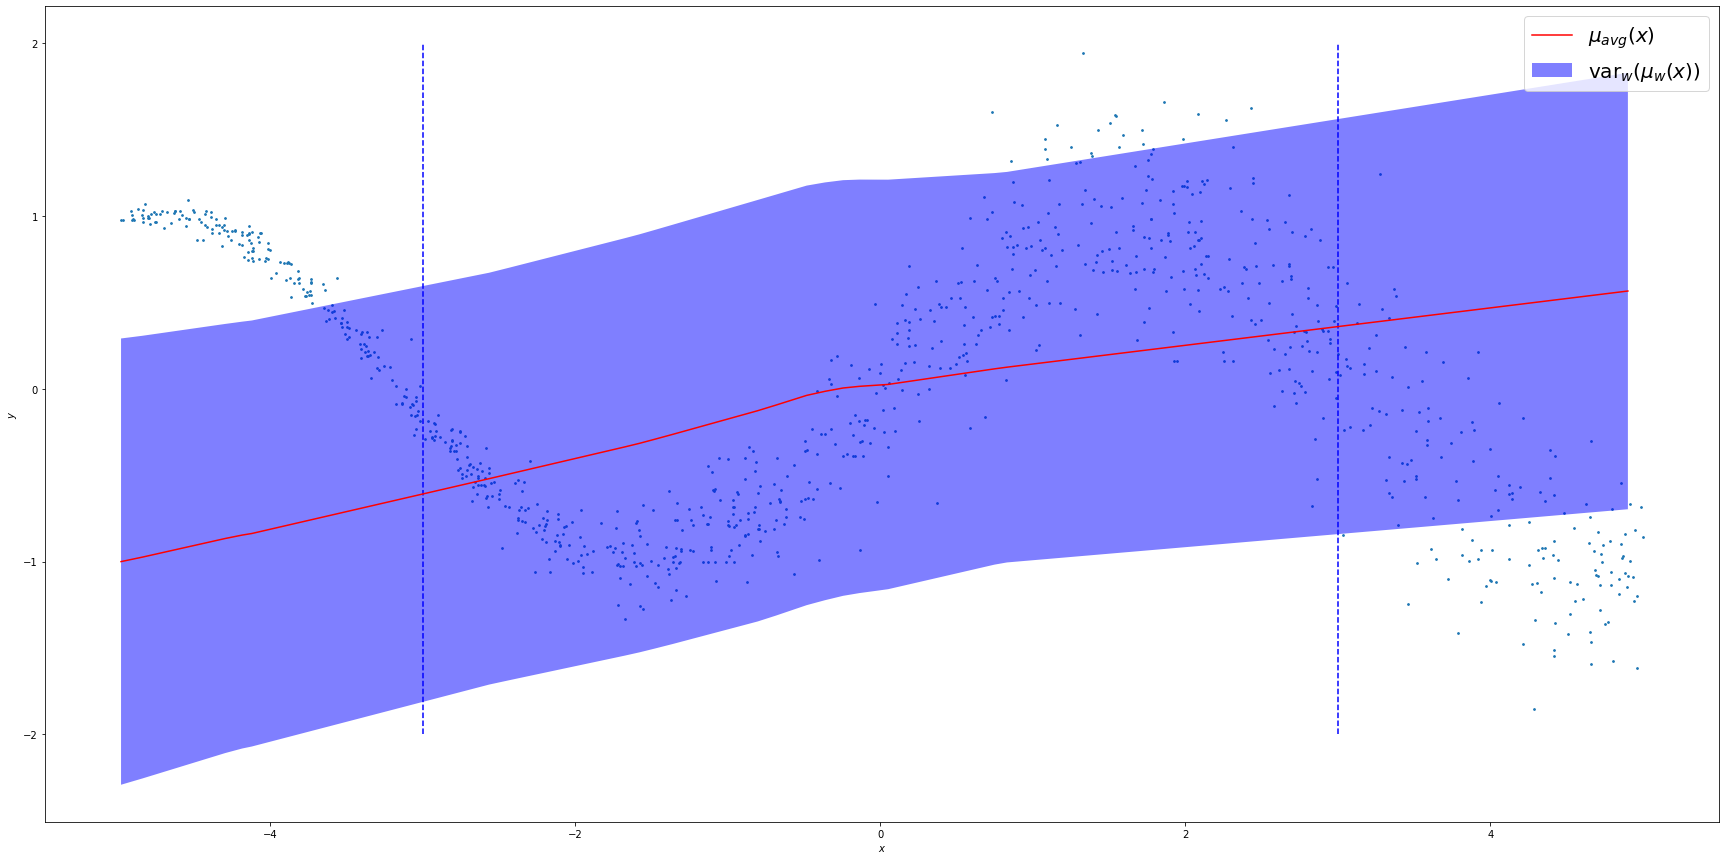

In [10]:
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    mu_mix, sigma_sq_mix = gauss_mix_distilled.forward(x.to(device))
    mu_mix, sigma_sq_mix = mu_mix.cpu().reshape(y.size()), sigma_sq_mix.cpu().reshape(y.size())
    x = x.reshape(y.size())
    

_, ax = plt.subplots()
utils.plot_uncert(ax, x, y, every_nth=10, mean_mu=mu_mix, ale=None, epi=sigma_sq_mix)
tikzplotlib.save("fig/toy_example/direct_distilled_mu_uncert.tikz")

torch.Size([1000, 1])
torch.Size([1000, 1])


torch.Size([1000, 1])

0.248458594083786 0.6961950063705444 0.22316773235797882


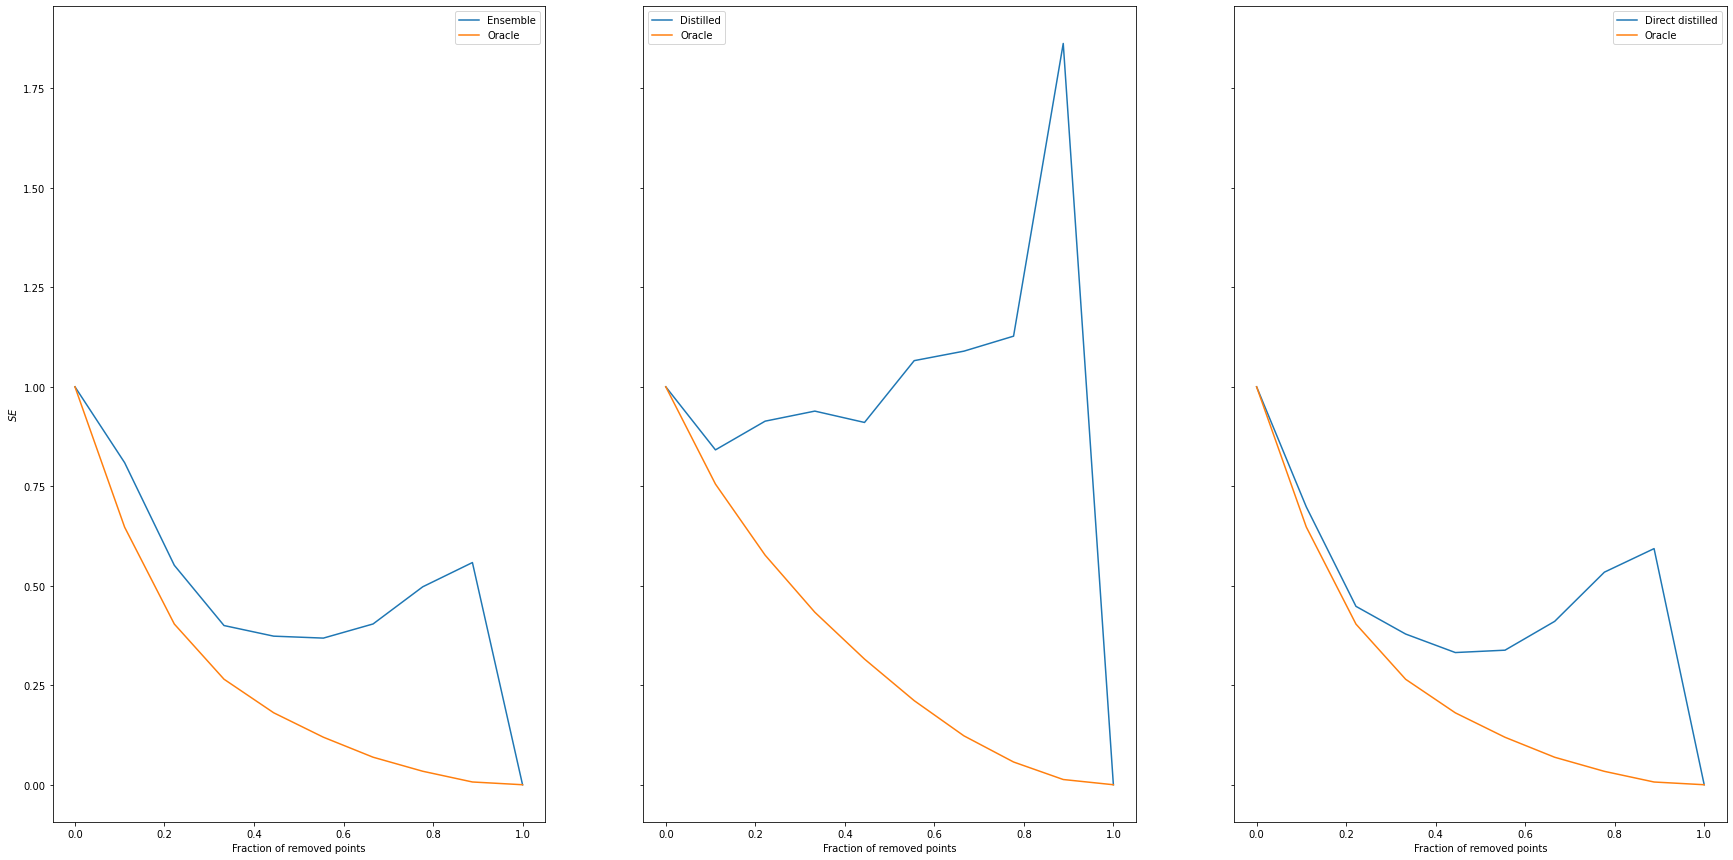

In [30]:
error = (y - mu_dist)**2
fig, (ax_ens, ax_dist, ax_mix) = plt.subplots(1, 3, sharey=True)

window_size = 20
uncert_ens = ale_ens + epi_ens
uncert_dist = ale_dist + epi_dist
uncert_mix = sigma_sq_mix

num_partitions = 10
# AUSE
utils.plot_sparsification_error(ax_ens,
                 y_true=y,
                 y_pred=mean_mu_ens,
                 uncert_meas=uncert_ens,
                 num_partitions=num_partitions,
                 label="Ensemble")

ause_ens = utils.ause(y_true=y,
           y_pred=mean_mu_ens,
           uncert_meas=uncert_ens,
           num_partitions=num_partitions)

utils.plot_sparsification_error(ax_dist,
                 y_true=y,
                 y_pred=mu_dist,
                 uncert_meas=uncert_dist,
                 num_partitions=num_partitions,
                 label="Distilled")
ause_dist = utils.ause(y_true=y,
           y_pred=mu_dist,
           uncert_meas=uncert_dist,
           num_partitions=num_partitions)

utils.plot_sparsification_error(ax_mix,
                 y_true=y,
                 y_pred=mu_mix,
                 uncert_meas=uncert_mix,
                 num_partitions=num_partitions,
                 label="Direct distilled")
ause_mix = utils.ause(y_true=y,
           y_pred=mu_mix,
           uncert_meas=uncert_mix,
           num_partitions=num_partitions)
#fig.set_xlabel("$x^{(i)}$")
ax_ens.set_ylabel("$SE$")

reg_dir = Path("Experiments/Regression/fig/")
#tikzplotlib.save(tex_dir/reg_dir/"toy_example/sparse_err.tikz")


print(ause_ens.item(), ause_dist.item(), ause_mix.item())

In [ ]:
reg_dir = Path("Experiments/Regression/data/")
utils.csv_result(result, file=tex_dir/reg_dir/(EXPERIMENT_NAME + ".csv"))